In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models

2025-06-19 01:37:43.984585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750297064.208869      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750297064.275581      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(df.shape)
df.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


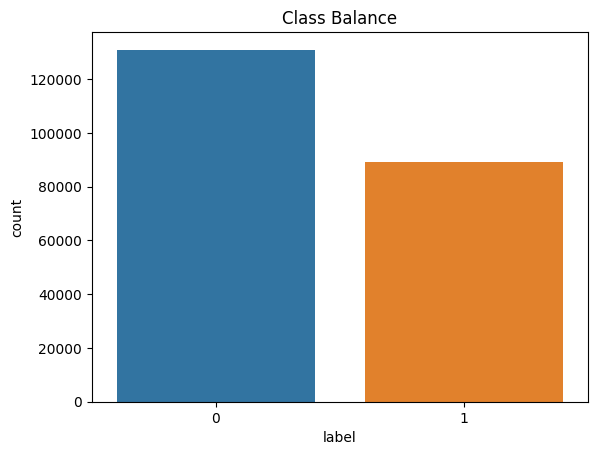

In [3]:
df = df.drop_duplicates()

# Check class distribution
sns.countplot(x='label', data=df)
plt.title("Class Balance")
plt.show()

In [4]:
SAMPLE_SIZE = 5000
df_sample = df.groupby('label').sample(SAMPLE_SIZE // 2, random_state=42).reset_index(drop=True)

def load_image(path):
    return np.array(Image.open(path).resize((96, 96)))

image_dir = '/kaggle/input/histopathologic-cancer-detection/train'

X = np.array([load_image(os.path.join(image_dir, f"{img_id}.tif")) for img_id in tqdm(df_sample['id'])])
y = df_sample['label'].values

100%|██████████| 5000/5000 [00:40<00:00, 121.98it/s]


In [5]:
X = X / 255.0
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-19 01:38:42.190294: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 233ms/step - accuracy: 0.5646 - loss: 0.7432 - val_accuracy: 0.7530 - val_loss: 0.5275
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.7375 - loss: 0.5422 - val_accuracy: 0.7580 - val_loss: 0.5225
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 228ms/step - accuracy: 0.7777 - loss: 0.4930 - val_accuracy: 0.7700 - val_loss: 0.5008
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.7978 - loss: 0.4468 - val_accuracy: 0.7420 - val_loss: 0.5260
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - accuracy: 0.8105 - loss: 0.4369 - val_accuracy: 0.7150 - val_loss: 0.5868


In [7]:
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7201 - loss: 0.5866
Validation Accuracy: 0.7150


In [8]:
test_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

def load_test_image(path):
    return np.array(Image.open(path).resize((96, 96))) / 255.0

test_image_dir = '/kaggle/input/histopathologic-cancer-detection/test'
test_paths = [os.path.join(test_image_dir, f"{img_id}.tif") for img_id in test_df['id']]

BATCH_SIZE = 512
test_preds = []

for i in tqdm(range(0, len(test_paths), BATCH_SIZE)):
    batch_paths = test_paths[i:i+BATCH_SIZE]
    
    batch_imgs = np.array([load_test_image(p) for p in batch_paths])
    
    batch_preds = model.predict(batch_imgs).flatten()
    test_preds.extend((batch_preds > 0.5).astype(int))

  0%|          | 0/113 [00:00<?, ?it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


  1%|          | 1/113 [00:05<09:34,  5.13s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


  2%|▏         | 2/113 [00:10<09:35,  5.18s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


  3%|▎         | 3/113 [00:15<09:41,  5.29s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


  4%|▎         | 4/113 [00:21<09:41,  5.34s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


  4%|▍         | 5/113 [00:26<09:30,  5.28s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


  5%|▌         | 6/113 [00:31<09:27,  5.30s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


  6%|▌         | 7/113 [00:36<09:17,  5.26s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


  7%|▋         | 8/113 [00:42<09:13,  5.27s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


  8%|▊         | 9/113 [00:47<09:05,  5.24s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


  9%|▉         | 10/113 [00:52<08:58,  5.23s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


 10%|▉         | 11/113 [00:58<09:03,  5.33s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


 11%|█         | 12/113 [01:03<08:52,  5.28s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


 12%|█▏        | 13/113 [01:08<08:47,  5.28s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 12%|█▏        | 14/113 [01:13<08:45,  5.30s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 13%|█▎        | 15/113 [01:19<08:40,  5.31s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 14%|█▍        | 16/113 [01:24<08:35,  5.31s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 15%|█▌        | 17/113 [01:29<08:26,  5.28s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


 16%|█▌        | 18/113 [01:35<08:25,  5.32s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


 17%|█▋        | 19/113 [01:40<08:11,  5.23s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 18%|█▊        | 20/113 [01:45<07:59,  5.15s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 19%|█▊        | 21/113 [01:50<07:52,  5.14s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 19%|█▉        | 22/113 [01:55<07:44,  5.11s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 20%|██        | 23/113 [02:00<07:36,  5.07s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


 21%|██        | 24/113 [02:05<07:30,  5.06s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 22%|██▏       | 25/113 [02:10<07:41,  5.24s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 23%|██▎       | 26/113 [02:16<07:46,  5.36s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 24%|██▍       | 27/113 [02:22<07:41,  5.36s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 25%|██▍       | 28/113 [02:27<07:34,  5.35s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


 26%|██▌       | 29/113 [02:32<07:24,  5.29s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 27%|██▋       | 30/113 [02:37<07:15,  5.24s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


 27%|██▋       | 31/113 [02:42<07:08,  5.22s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


 28%|██▊       | 32/113 [02:47<07:02,  5.21s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 29%|██▉       | 33/113 [02:52<06:51,  5.15s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 30%|███       | 34/113 [02:57<06:43,  5.11s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 31%|███       | 35/113 [03:02<06:35,  5.07s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


 32%|███▏      | 36/113 [03:08<06:33,  5.11s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 33%|███▎      | 37/113 [03:13<06:33,  5.18s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


 34%|███▎      | 38/113 [03:18<06:32,  5.24s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 35%|███▍      | 39/113 [03:24<06:29,  5.26s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


 35%|███▌      | 40/113 [03:29<06:25,  5.28s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 36%|███▋      | 41/113 [03:34<06:23,  5.32s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


 37%|███▋      | 42/113 [03:40<06:16,  5.31s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


 38%|███▊      | 43/113 [03:45<06:11,  5.31s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 39%|███▉      | 44/113 [03:50<06:05,  5.30s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 40%|███▉      | 45/113 [03:55<05:57,  5.25s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 41%|████      | 46/113 [04:01<05:53,  5.27s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 42%|████▏     | 47/113 [04:06<05:50,  5.31s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


 42%|████▏     | 48/113 [04:12<05:51,  5.41s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 43%|████▎     | 49/113 [04:17<05:48,  5.44s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 44%|████▍     | 50/113 [04:23<05:41,  5.42s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


 45%|████▌     | 51/113 [04:28<05:35,  5.40s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


 46%|████▌     | 52/113 [04:33<05:27,  5.38s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 47%|████▋     | 53/113 [04:39<05:21,  5.35s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 48%|████▊     | 54/113 [04:44<05:13,  5.31s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 49%|████▊     | 55/113 [04:49<05:06,  5.29s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


 50%|████▉     | 56/113 [04:54<04:59,  5.26s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 50%|█████     | 57/113 [05:00<04:54,  5.25s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 51%|█████▏    | 58/113 [05:05<04:50,  5.28s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


 52%|█████▏    | 59/113 [05:10<04:45,  5.28s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


 53%|█████▎    | 60/113 [05:16<04:42,  5.32s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


 54%|█████▍    | 61/113 [05:21<04:39,  5.37s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 55%|█████▍    | 62/113 [05:27<04:35,  5.40s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 56%|█████▌    | 63/113 [05:32<04:26,  5.32s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 57%|█████▋    | 64/113 [05:37<04:19,  5.30s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 58%|█████▊    | 65/113 [05:42<04:11,  5.24s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


 58%|█████▊    | 66/113 [05:47<04:07,  5.27s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


 59%|█████▉    | 67/113 [05:53<04:06,  5.36s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


 60%|██████    | 68/113 [05:58<03:57,  5.28s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 61%|██████    | 69/113 [06:03<03:49,  5.22s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


 62%|██████▏   | 70/113 [06:08<03:45,  5.23s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 63%|██████▎   | 71/113 [06:14<03:41,  5.27s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


 64%|██████▎   | 72/113 [06:19<03:39,  5.34s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


 65%|██████▍   | 73/113 [06:25<03:37,  5.44s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


 65%|██████▌   | 74/113 [06:30<03:31,  5.42s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 66%|██████▋   | 75/113 [06:36<03:25,  5.40s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


 67%|██████▋   | 76/113 [06:41<03:18,  5.35s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 68%|██████▊   | 77/113 [06:46<03:12,  5.34s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


 69%|██████▉   | 78/113 [06:51<03:05,  5.29s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


 70%|██████▉   | 79/113 [06:57<03:01,  5.33s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 71%|███████   | 80/113 [07:02<02:52,  5.24s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 72%|███████▏  | 81/113 [07:07<02:47,  5.22s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 73%|███████▎  | 82/113 [07:12<02:44,  5.30s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


 73%|███████▎  | 83/113 [07:18<02:43,  5.45s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


 74%|███████▍  | 84/113 [07:24<02:38,  5.47s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


 75%|███████▌  | 85/113 [07:30<02:37,  5.61s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 76%|███████▌  | 86/113 [07:35<02:31,  5.59s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


 77%|███████▋  | 87/113 [07:41<02:25,  5.58s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


 78%|███████▊  | 88/113 [07:46<02:19,  5.59s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 79%|███████▉  | 89/113 [07:52<02:11,  5.49s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


 80%|███████▉  | 90/113 [07:57<02:06,  5.52s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


 81%|████████  | 91/113 [08:03<02:03,  5.63s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


 81%|████████▏ | 92/113 [08:09<02:00,  5.75s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 82%|████████▏ | 93/113 [08:15<01:55,  5.80s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 83%|████████▎ | 94/113 [08:21<01:51,  5.89s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


 84%|████████▍ | 95/113 [08:27<01:46,  5.92s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


 85%|████████▍ | 96/113 [08:33<01:39,  5.88s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


 86%|████████▌ | 97/113 [08:39<01:35,  5.94s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 87%|████████▋ | 98/113 [08:45<01:29,  5.95s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


 88%|████████▊ | 99/113 [08:51<01:22,  5.87s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 88%|████████▊ | 100/113 [08:56<01:15,  5.82s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


 89%|████████▉ | 101/113 [09:02<01:09,  5.81s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


 90%|█████████ | 102/113 [09:08<01:04,  5.83s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


 91%|█████████ | 103/113 [09:13<00:56,  5.68s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


 92%|█████████▏| 104/113 [09:19<00:51,  5.73s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 93%|█████████▎| 105/113 [09:25<00:46,  5.80s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 94%|█████████▍| 106/113 [09:30<00:39,  5.61s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


 95%|█████████▍| 107/113 [09:36<00:32,  5.46s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


 96%|█████████▌| 108/113 [09:41<00:27,  5.41s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 96%|█████████▋| 109/113 [09:46<00:21,  5.28s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 97%|█████████▋| 110/113 [09:51<00:15,  5.20s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


 98%|█████████▊| 111/113 [09:56<00:10,  5.13s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


 99%|█████████▉| 112/113 [10:00<00:05,  5.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


100%|██████████| 113/113 [10:02<00:00,  5.33s/it]


In [9]:
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'label': test_preds
})
submission_df.to_csv('/kaggle/working/submission.csv', index=False)